<a href="https://colab.research.google.com/github/AbdelrahmanTamer11/Machine-Translation-With-Sequence-to-Sequence-Models/blob/main/Machine_Translation_With_Sequence_to_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load the dataset
data_path = '/content/eng_-french.csv'
data = pd.read_csv(data_path)

In [3]:
# Clean and preprocess the text
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
# Preprocess both English and French sentences
data['English words/sentences'] = data['English words/sentences'].apply(preprocess_sentence)
data['French words/sentences'] = data['French words/sentences'].apply(preprocess_sentence)

In [5]:
# Tokenize the sentences
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(data['English words/sentences'])
eng_sequences = eng_tokenizer.texts_to_sequences(data['English words/sentences'])


fre_tokenizer = Tokenizer()
fre_tokenizer.fit_on_texts(data['French words/sentences'])
fre_sequences = fre_tokenizer.texts_to_sequences(data['French words/sentences'])

In [6]:
# Padding the sequences
max_eng_len = max(len(seq) for seq in eng_sequences)
max_fre_len = max(len(seq) for seq in fre_sequences)

eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fre_padded = pad_sequences(fre_sequences, maxlen=max_fre_len, padding='post')

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(eng_padded, fre_padded, test_size=0.2)

In [8]:
# Define vocab sizes
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fre_vocab_size = len(fre_tokenizer.word_index) + 1

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

In [10]:
# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
encoder_embedding = Embedding(eng_vocab_size, 256)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(256, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

In [11]:
# Decoder
decoder_inputs = Input(shape=(max_fre_len,))
decoder_embedding = Embedding(fre_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=False)(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(fre_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm)

In [12]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 47)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 61)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 47, 256)        │      3,559,424 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 61, 256)        │      5,117,952 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        525,312 │ embedding[0][0]        │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 61, 256)        │        525,312 │ embedding_1[0][0],     │
│                           │                        │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 61, 19992)      │      5,137,944 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,865,944 (56.71 MB)

 Trainable params: 14,865,944 (56.71 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Prepare the target data by shifting the decoder's output
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [16]:
# Train the model
history = model.fit([X_train, y_train], y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 221s 123ms/step - accuracy: 0.9027 - loss: 0.9947 - val_accuracy: 0.9774 - val_loss: 0.1884
Epoch 2/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 260s 123ms/step - accuracy: 0.9832 - loss: 0.1432 - val_accuracy: 0.9918 - val_loss: 0.0734
Epoch 3/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 262s 124ms/step - accuracy: 0.9934 - loss: 0.0563 - val_accuracy: 0.9954 - val_loss: 0.0413
Epoch 4/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 262s 123ms/step - accuracy: 0.9964 - loss: 0.0279 - val_accuracy: 0.9970 - val_loss: 0.0284
Epoch 5/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 262s 123ms/step - accuracy: 0.9979 - loss: 0.0149 - val_accuracy: 0.9978 - val_loss: 0.0220
Epoch 6/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 262s 124ms/step - accuracy: 0.9988 - loss: 0.0076 - val_accuracy: 0.9983 - val_loss: 0.0186
Epoch 7/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 233s 133ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9985 - val_loss: 0.0168
Epoch 8/10
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 217s 123ms/step - ac

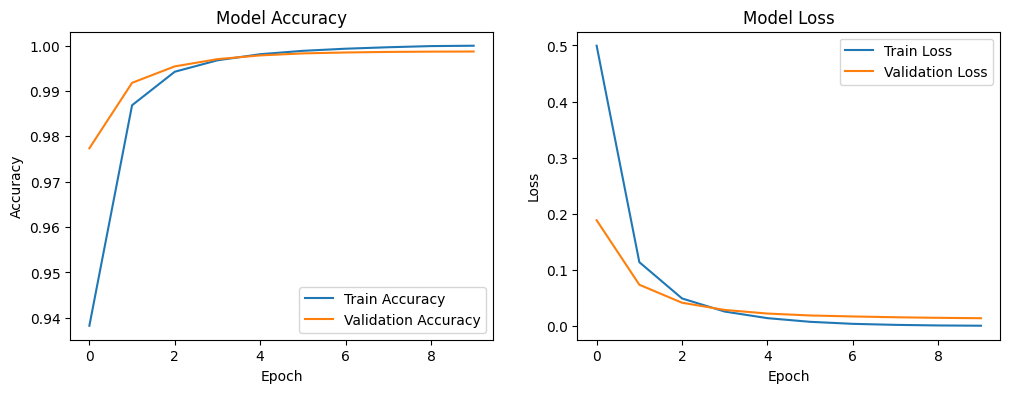

In [17]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test, y_test], y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9987 - loss: 0.0135
Test Loss: 0.013415494002401829
Test Accuracy: 0.998740017414093
